# Call libraries 

In [1]:
import copy
import math
import cmath
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#import matplotlib as mpl

%matplotlib inline
#%matplotlib nbagg

from func import paramin, indexin

# Input from excel file

In [2]:
days_to_compute = 3

test=[*range(0,days_to_compute)]
weather_data=pd.read_excel('weather.xlsx',sheet_name=test,header=0)

In [3]:
weather_data.keys()

dict_keys([0, 1, 2])

In [4]:
weather_data[0].columns

Index(['Time [h]', 'Tatm [ºC]', 'DewPoint [ºF]', 'SolarRad [W/m²]',
       'WindSpeed [mph]'],
      dtype='object')

# Polynomial cubic fit / wind speed

In [5]:
def wind_cubic(x,a,b,c,d):
    cubic_fit=a*(x**3)+b*(x**2)+c*x+d
    return cubic_fit

wind_param=np.zeros((days_to_compute,4))
wind_stderr=np.zeros((days_to_compute,4,4))

for i in range(days_to_compute):
    wind_param[i,:],wind_stderr[i,:,:]=curve_fit(wind_cubic,weather_data[i]['Time [h]'], \
                                                weather_data[i]['WindSpeed [mph]'])

In [6]:
wind_approx=np.zeros((days_to_compute,len(weather_data[0]['Time [h]'])))
wind_r2=np.zeros((days_to_compute))

for i in range(days_to_compute):
    wind_approx[i,:] = wind_cubic(weather_data[i]['Time [h]'],*wind_param[i,:])
    residuals = weather_data[i]['WindSpeed [mph]']-wind_approx[i,:]
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((weather_data[i]['WindSpeed [mph]']-np.mean(weather_data[i]['WindSpeed [mph]']))**2)
    wind_r2[i] = 1 - (ss_res / ss_tot)
    
for i in range(days_to_compute):
    for t in range(len(wind_approx[i,:])):
        if wind_approx[i,t]<0: wind_approx[i,t]=0

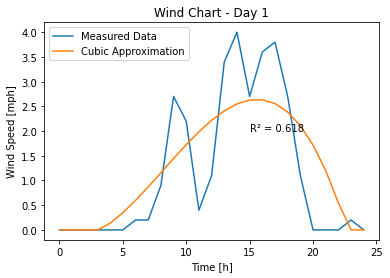

Cubic interpolation parameters [a,b,c,d] = [-0.00178688  0.04413618 -0.0740587  -0.16123077]


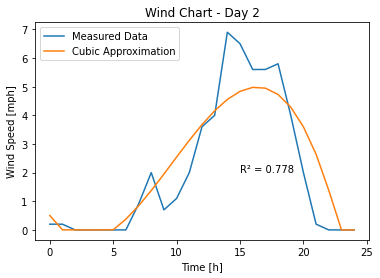

Cubic interpolation parameters [a,b,c,d] = [-0.00437671  0.12637056 -0.62190839  0.50242737]


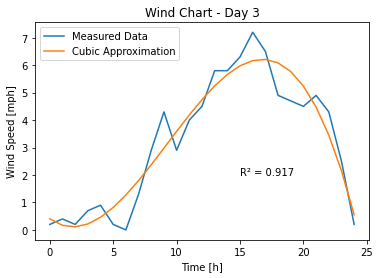

Cubic interpolation parameters [a,b,c,d] = [-0.00365714  0.10203236 -0.33623847  0.40622222]


In [7]:
for i in range(days_to_compute):
    plt.plot(weather_data[i]['Time [h]'],weather_data[i]['WindSpeed [mph]'])
    plt.plot(weather_data[i]['Time [h]'],wind_approx[i,:])
    plt.title('Wind Chart - Day {}'.format(i+1))
    plt.ylabel('Wind Speed [mph]')
    plt.xlabel('Time [h]')
    plt.legend(['Measured Data','Cubic Approximation'])
    plt.text(15,2,'R² = '+str(round(wind_r2[i],3)))
    plt.show()
    print('Cubic interpolation parameters [a,b,c,d] =',wind_param[i,:])

# "Sewing" Input

In [8]:
time = np.arange((len(weather_data[0]['Time [h]'])-1)*days_to_compute+1)

temp_atm = [weather_data[0]['Tatm [ºC]'][0]]
temp_dewpt = [weather_data[0]['DewPoint [ºF]'][0]]
solar_rad = [weather_data[0]['SolarRad [W/m²]'][0]]
wind_speed = [wind_approx[0,0]]

for i in range(days_to_compute):
    temp_atm.extend(weather_data[i]['Tatm [ºC]'][1:].tolist())
    temp_dewpt.extend(weather_data[i]['DewPoint [ºF]'][1:].tolist())
    solar_rad.extend(weather_data[i]['SolarRad [W/m²]'][1:].tolist())
    wind_speed.extend(wind_approx[i,1:].tolist())

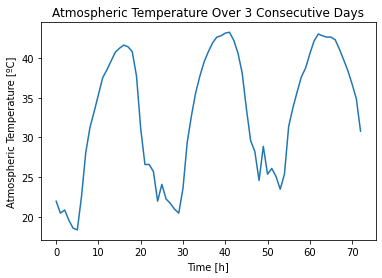

In [9]:
plt.plot(time,temp_atm)
plt.title('Atmospheric Temperature Over '+str(days_to_compute)+' Consecutive Days')
plt.xlabel('Time [h]')
plt.ylabel('Atmospheric Temperature [ºC]')
plt.show()

# NOTE : FORCED CONTINUITY == JUMPS AT 12PM-1AM DUE TO DATA SET
# Tatm(12PM,day1) =/= Tatm(1AM,day2) WHEN SHOULD BE


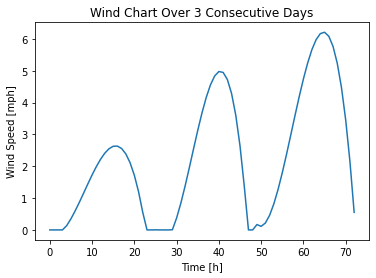

In [10]:
plt.plot(time,wind_speed)
plt.title('Wind Chart Over '+str(days_to_compute)+' Consecutive Days')
plt.xlabel('Time [h]')
plt.ylabel('Wind Speed [mph]')
plt.show()

# NOTE : SAME AS BEFORE, BUT EVEN WITH GOOD DATA, USING CUBIC POLY CAN
#        ALTER THE CONTINUITY ANYWAY


# Linear Interpolation

In [11]:
time = np.arange((len(weather_data[0]['Time [h]'])-1)*days_to_compute+1)
time_step = 120 # [s]
time_sec = time*3600 # [s]
time_interp = np.arange(0,time_sec[-1]+time_step,time_step) # [s]

temp_atm_interp = np.interp(time_interp,time_sec,temp_atm)
temp_dewpt_interp = np.interp(time_interp,time_sec,temp_dewpt)
solar_rad_interp = np.interp(time_interp,time_sec,solar_rad)
wind_speed_interp = np.interp(time_interp,time_sec,wind_speed)

# Unit Conversion 

In [12]:
temp_atm_interp += 273.15 # [ºC] to [K]
temp_dewpt_interp = (temp_dewpt_interp-32)/1.8 # [ºF] to [ºC]
wind_speed_interp *= (16/36) # [mph] to [m/s]

for k in range(len(wind_speed_interp)): 
    if wind_speed_interp[k]<0: wind_speed_interp[k]=0

# Soil Properties 

In [13]:
number_of_layers = 2

density=[2085,2200] # [kg/m³]
spec_heat_capacity=[1298,920] # [J/kg/K]
thermal_conductivity=[0.741,1.20] # [W/m/K]

# node_spacing=0.01 # [m] ~ 0.5 inches

# instability in calculation even with CFL OK > test higher node_spacing
node_spacing=0.0127 # [m] ~ 0.5 inches

pavement_thickness=[round(6.0*0.0254,2)] # [m]
interface_contact_res=[0.001]

surface_albedo=0.15
surface_emissivity=0.97

deep_ground_temp=22.0+273.15 # [K]
ground_layer_depth=3  # [m]

sky_view_factor=0.95
solar_view_factor=0.85

characteristic_length=1 # [m]

In [14]:
pavement_depth=np.zeros(len(pavement_thickness))
pavement_depth[0]=pavement_thickness[0]
for k in range(1,len(pavement_thickness)):
    pavement_depth[k]=pavement_depth[k-1]+pavement_thickness[k]

# Preliminary Calculations and Input

## Outgoing radiation properties

$$T_{sky}=T_{atm}\left(0.004T_{dew}+0.8\right)^{0.25}$$

With:  
-- $T_{sky}$ the sky temperature [K]  
-- $T_{atm}$ the atmospheric dry-bulb temperature [K]  
-- $T_{dew}$ the dew-point temperature [ºC]

In [15]:
stefan_boltzmann=5.67e-8 # [W/m²/K⁴]

In [16]:
temp_sky_interp = temp_atm_interp*(0.004*temp_dewpt_interp+0.8)**(0.25)

## Reference air film properties

In [17]:
ref_temp_flow=[300,350]
ref_viscosity_flow=[1.589e-05,2.092e-05]
ref_conductivity_flow=[2.630e-02,3.000e-02]
ref_diffusivity_flow=[2.250e-05,2.990e-05]
ref_prandtl_flow=[0.707,0.700]

# Formulae used within the Time-Space Recurring Scheme

## Radiation coefficient calculation

Outgoing radiation coefficient **depends on SURFACE temperature**:  

$$h_{rad}=\Psi_{sky}\varepsilon\sigma\left(T_{surface}^2+T_{sky}^2\right)\left(T_{surface}+T_{sky}\right)$$  

With:  
-- $h_{rad}$ the abbreviated parameter for outgoing radiative coefficient []  
-- $\Psi_{sky}$ the sky view factor []  
-- $\varepsilon$ the infrared emissivity of the surface []  
-- $\sigma=5.67e^{-8}$ the Stefan-Boltzmann constant [W/m²/K⁴]  
-- $T_{surface}$ the pavement surface temperature [K]

## Convection heat transfer calculation

Air film temperature **depends on SURFACE temperature**:

$$T_{film}=\frac{T_{surface}+T_{atm}}{2}$$

$T_{film}$ is then used together with the ***Reference air film properties*** to interpolated or extrapolate the **acutal** air film properties:  

-- viscosity $\nu_{film}\left(T_{film}\right)$  
-- conductivity $k_{film}\left(T_{film}\right)$  
-- diffusivity $\alpha_{film}\left(T_{film}\right)$  
-- Prandtl number $Pr\left(T_{film}\right)$

### Reynolds number of air film

**Laminar or turbulent air flow ?**

$$Re=\frac{U_{film}L}{\nu_{film}}$$

With:  
-- $Re$ the Reynolds number of air []  
-- $U_{film}$ the wind velocity [m/s]  
-- $L$ the characteristic length of the pavement [m]  
-- $\nu_{film}$ the kinematic viscosity of air [m²/s]  

**If $Re<5e^5$, then the flow is laminar.  
Else it is turbulent.**

### Nusselt number of air film in function of laminar/turbulent flow

For laminar flow:  
$$Nu_{laminar}=0.664\left[Pr^{1/3}Re^{0.5}\right]$$

For turbulent flow:
$$Nu_{turbulent}=0.037\left[Pr^{1/3}Re^{0.8}\right]$$

With:  
-- $Nu_{xxx}$ the Nusselt number of air []  
-- $Pr$ the Prandtl number of air []  

### Convective heat transfer coefficient of air hinf

For laminar flow:  
$$h_{laminar}=0.664\left[k_{film}Pr^{1/3}\nu_{film}^{-0.5}L^{-0.5}U_{film}^{0.5}\right]$$
$$h_{laminar}=Nu_{laminar}\frac{k_{film}}{L}$$

For turbulent flow:
$$h_{turbulent}=0.037\left[k_{film}Pr^{1/3}\nu_{film}^{-0.8}L^{-0.2}U_{film}^{0.8}\right]$$
$$h_{turbulent}=Nu_{turbulent}\frac{k_{film}}{L}$$

With:  
-- $h_{xxx}$ the convective heat transfer coefficient of air []  
-- $k_{film}$ the thermal conductivity of air [W/m/K]  

## Stability verification

Calculate Courant-Friedrichs-Lewy - CFL criterion at all time

$$\Delta t \leq \frac{\rho_{surf}c_{surf}\Delta x^2}{2\left(h_{rad}\Delta x + h_{laminar}\Delta x + k_{surf}\right)}$$

OR  

$$\Delta t \leq \frac{\rho_{surf}c_{surf}\Delta x^2}{2\left(h_{rad}\Delta x + h_{turbulent}\Delta x + k_{surf}\right)}$$

With:  
-- $\Delta t$ the temporal discretization step [s]  
-- $\rho_{surf}$ the density of the surface layer [kg/m³]  
-- $c_{surf}$ the specific heat capacity of the surface layer [J/kg/K]  
-- $\Delta x$ the spatial discretization step [m]  
-- $k_{surf}$ the thermal conductivity of the surface layer [W/m/K]

## Coefficient calculations for non-surface depths

In [18]:
delta_calc = np.zeros((number_of_layers))
A = np.zeros((number_of_layers))
B = np.zeros((number_of_layers))
C=np.zeros((len(pavement_depth)))
D=np.zeros((len(pavement_depth)))

for layer in range(number_of_layers):
    delta_calc[layer] = (2*time_step)/(density[layer]*spec_heat_capacity[layer]*node_spacing)
    A[layer] = 1-(delta_calc[layer]*thermal_conductivity[layer]/node_spacing)
    B[layer] = 0.5*delta_calc[layer]*thermal_conductivity[layer]/node_spacing

for interface in range(len(pavement_depth)):
    C[interface]=(2*node_spacing*thermal_conductivity[interface] \
                  + thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface]) \
                  / (2* (thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface] \
                       + node_spacing*thermal_conductivity[interface]+node_spacing*thermal_conductivity[interface+1]))
    D[interface]=(2*node_spacing*thermal_conductivity[interface+1] \
                  + thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface]) \
                  / (2* (thermal_conductivity[interface]*thermal_conductivity[interface+1]*interface_contact_res[interface] \
                       + node_spacing*thermal_conductivity[interface]+node_spacing*thermal_conductivity[interface+1]))

print('[delta1,delta2] =',delta_calc)
print('[A1,A2] =',A)
print('[B1,B2] =',B)
print('C12 =',C)
print('D12 =',D)

[delta1,delta2] = [0.00698275 0.00933678]
[A1,A2] = [0.59258102 0.1177848 ]
[B1,B2] = [0.20370949 0.4411076 ]
C12 = [0.38587857]
D12 = [0.61412143]


## Coefficient calculations for SURFACE

$delta\_surf$ and $Bsurf$ are **CONSTANT** (no recurrence iteration needed).  
$Asurf$ and $Csurf$ are have a recurrent dependence, and are thus calculated within the non-linear loops

In [19]:
delta_surf = (2*time_step)/(density[0]*spec_heat_capacity[0]*node_spacing)
Bsurf = delta_surf*thermal_conductivity[0]/node_spacing
print('delta_surf =',delta_surf)
print('Bsurf =',Bsurf)

delta_surf = 0.006982754429532095
Bsurf = 0.4074189789199435


# Time-Space Recurring Scheme ( > non-linear iterations )

In [20]:
profile = np.zeros((len(time_interp),int(ground_layer_depth/node_spacing)+1))

hrad = np.zeros((len(time_interp)))
convective_heat_air = np.zeros((len(time_interp)))
delta_t = np.zeros((len(time_interp)))
Asurf = np.zeros((len(time_interp)))
Csurf = np.zeros((len(time_interp)))
normM = np.zeros((len(time_interp)))

stab_flag = False

for ite in range(50):
    
    '''
    print('\n')
    print('##############')
    print('  nlin_ite'+str(ite+1))
    print('##############')
    '''
    
    if ite==0:
        profile[:,:].fill(deep_ground_temp)
    
    profile_old=copy.copy(profile)
    
    for time in range(0,profile.shape[0]):
    #for time in range(1):
        
        ##### hrad calculation #####
        hrad[time] = sky_view_factor*surface_emissivity*stefan_boltzmann*(profile[time-1,0]**2+temp_sky_interp[time]**2)*(profile[time-1,0]+temp_sky_interp[time])
        ############################
        
        ##### air film properties calculation #####
        film_temp = 0.5*(profile[time-1,0]+temp_atm_interp[time])
        film_viscosity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                         *(ref_viscosity_flow[1]-ref_viscosity_flow[0])+ref_viscosity_flow[0]
        film_conductivity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                            *(ref_conductivity_flow[1]-ref_conductivity_flow[0])+ref_conductivity_flow[0]
        film_diffusivity = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                            *(ref_diffusivity_flow[1]-ref_diffusivity_flow[0])+ref_diffusivity_flow[0]
        film_prandtl = ((film_temp-ref_temp_flow[0])/(ref_temp_flow[1]-ref_temp_flow[0])) \
                       *(ref_prandtl_flow[1]-ref_prandtl_flow[0])+ref_prandtl_flow[0]
        film_beta = 1 / film_temp

        film_reynolds = wind_speed_interp[time] * characteristic_length / film_viscosity
        film_nusselt_laminar = 0.664 * film_reynolds**(0.5) * film_prandtl**(1/3)
        film_nusselt_turbulent = 0.037 * film_reynolds**(0.8) * film_prandtl**(1/3)

        if film_reynolds<5e5:
            film_nusselt_actual=film_nusselt_laminar
        else:
            film_nusselt_actual=film_nusselt_turbulent
            print('WATCH OUT : Turbulent flow!')
        ###########################################
        
        ##### hinf calculation (from air film prop) #####
        convective_heat_air[time] = film_nusselt_actual * film_conductivity / characteristic_length
        #################################################
        
        ##### CFL criterion validation #####
        delta_t[time]=(node_spacing**2)*density[0]*spec_heat_capacity[0] / (2*(hrad[time]*node_spacing+convective_heat_air[time]*node_spacing+thermal_conductivity[0]))
        stability = delta_t[time] > time_step
        
        if stability==False: 
            print('Unstable FD scheme, breaking!')
            stab_flag = True
            break
        ####################################
        
        ##### A & C surface coefficients #####
        Asurf[time] = 1-(delta_surf*(hrad[time]+convective_heat_air[time]+thermal_conductivity[0]/node_spacing))
        Csurf[time] = delta_surf*(hrad[time]*temp_sky_interp[time]+convective_heat_air[time]*temp_atm_interp[time] + \
                           solar_view_factor*(1-surface_albedo)*solar_rad_interp[time])
        ######################################       
        
        for depth in range(profile.shape[1]):
            depth_m=round(depth*node_spacing,2)
            if depth_m==0:
                profile[time,depth] = Asurf[time]*profile[time-1,depth]+Bsurf*profile[time-1,depth+1]+Csurf[time]
                
            elif depth_m<=pavement_depth[-1]:
                for interface in range(len(pavement_depth)):
                    if depth_m<pavement_depth[interface]:
                        profile[time,depth] = A[interface]*profile[time-1,depth] \
                                            + B[interface]*(profile[time-1,depth-1]+profile[time-1,depth+1])
                        break

                    elif depth_m==pavement_depth[interface]:
                        profile[time,depth] = C[interface]*profile[time,depth-1] \
                                            + D[interface]*profile[time,depth+1]
                        break

            elif depth_m!=ground_layer_depth:
                profile[time,depth] = A[-1]*profile[time-1,depth] \
                                    + B[-1]*(profile[time-1,depth-1]+profile[time-1,depth+1])

            else:
                profile[time,depth] = deep_ground_temp

    if stab_flag == True:
        break
    
    profile_diff=profile_old-profile
    normM[time] = np.linalg.norm(profile_diff,'fro')
    
    print('\n')
    print('############################################')
    print('FROBENIUS MATRIX NORM Fnorm(X)')
    print('X = profile[nlin_ite'+str(ite)+'] - profile[nlin_ite'+str(ite+1)+']')
    print('Fnorm(X) = ',normM[time])
    print('############################################')
    
    if normM[time]<=50:
        print('\nCONVERGENCE CRITERION Fnorm(X)<50 REACHED!')
        break



############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite0] - profile[nlin_ite1]
Fnorm(X) =  2196.527129731653
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite1] - profile[nlin_ite2]
Fnorm(X) =  290.3912935060471
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite2] - profile[nlin_ite3]
Fnorm(X) =  230.4458721382675
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite3] - profile[nlin_ite4]
Fnorm(X) =  237.45068153129588
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite4] - profile[nlin_ite5]
Fnorm(X) =  241.58569231091622
############################################


###########



############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite42] - profile[nlin_ite43]
Fnorm(X) =  85.2706936268713
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite43] - profile[nlin_ite44]
Fnorm(X) =  82.31332767840273
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite44] - profile[nlin_ite45]
Fnorm(X) =  79.45707176515701
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite45] - profile[nlin_ite46]
Fnorm(X) =  76.69869008224181
############################################


############################################
FROBENIUS MATRIX NORM Fnorm(X)
X = profile[nlin_ite46] - profile[nlin_ite47]
Fnorm(X) =  74.03501375092054
############################################


####

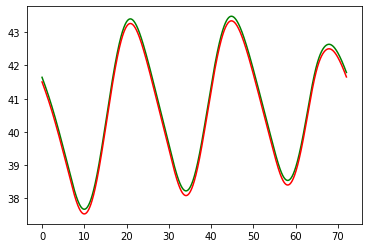

In [21]:
plt.plot(time_interp/3600,profile[:,15]-273.15,'green')
plt.plot(time_interp/3600,profile_old[:,15]-273.15,'red')

In [25]:
print(max(profile[:,15]-273.15))
print(min(profile[:,15]-273.15))
print(np.mean(profile[:,15]-273.15))

43.48355767042159
37.668511504011576
40.744618354061316


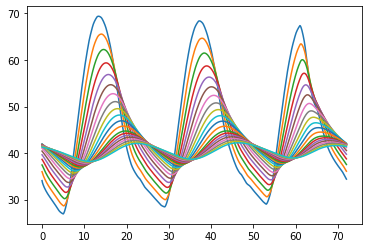

In [26]:
for k in range(20):
    plt.plot(time_interp/3600,profile[:,k]-273.15)

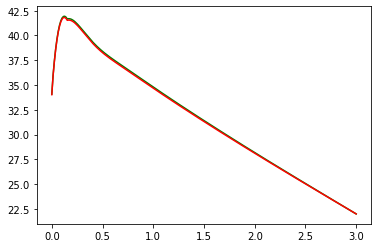

In [27]:
plt.plot(np.linspace(0,ground_layer_depth,profile.shape[1]),profile[0,:]-273.15,'green')
plt.plot(np.linspace(0,ground_layer_depth,profile.shape[1]),profile_old[0,:]-273.15,'red')

In [24]:
a = [1,2]
print('a =',a)
b = a
print('b =',b)
a[0]=3
print('a =',a)
print('b =',b)

a = [1, 2]
b = [1, 2]
a = [3, 2]
b = [3, 2]
